In [1]:
%matplotlib inline
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import numpy.ma as ma
from matplotlib.colors import ListedColormap
from datetime import datetime, timedelta
import matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import os
import math

In [2]:
dateBegin = datetime(2020, 1, 1)
dateEnd = datetime(2020, 1, 31)
days = np.arange(dateBegin, dateEnd, timedelta(days=1)).astype(datetime)
hours = np.arange(dateBegin, dateEnd, timedelta(hours=0.5)).astype(datetime)
#print(days)
timeseries = []
heightTimeseries = np.zeros((len(days),300))

In [3]:
heightGrid = list(range(0,15000,50))
heightGridDf = pd.DataFrame({'height': heightGrid})

def mergeHeight(heightList):
    # map height
    knn = NearestNeighbors(n_neighbors=1)
    knn.fit(heightList)
    return knn.kneighbors(heightGridDf, return_distance=False)

In [4]:
from datetime import datetime, timedelta
gridTimeSeries = []
for entry in hours:
    gridTimeSeries.append(datetime.timestamp(entry))
gridDf = pd.DataFrame({'time': gridTimeSeries})  
def timeknn(TimeSeries):

    
    
    
    #Target Grid
    targetTimeList = []
    for entry in TimeSeries:
        stamp = (entry-2440587.5)*86400
        targetTimeList.append(stamp)
    targetDf = pd.DataFrame({'time': targetTimeList})
    
    #KNN
    knn = NearestNeighbors(n_neighbors=1)
    knn.fit(targetDf)
    matchList = knn.kneighbors(gridDf, return_distance=True)
    

    #generate result
    resultList = []
    for i in range(len(gridTimeSeries)):
        iMatch = int(matchList[1][i])
        if matchList[0][i] <= 60*14: #14 Minuten
            resultList.append(iMatch)
        else:
            resultList.append(np.nan)
    return resultList

In [5]:
radarList = np.zeros((len(days),300))
lidarList = np.zeros((len(days),300))
both = np.zeros((len(days),300))

def readFile(n, pathRadar, pathLidar):
    #Radar
    if os.path.exists(pathRadar):
        datasetRadar = Dataset(pathRadar, mode='r')
        heightRadar = datasetRadar.variables['height'][:]
        heightRadarDf = pd.DataFrame({'height': heightRadar})
        speedRadar = datasetRadar.variables['speed'][:]
        speedRadar = speedRadar.filled(np.nan)
        timeRadar = datasetRadar.variables['time'][:]
        speedRadar = speedRadar.T
        matchRadarIndex = mergeHeight(heightRadarDf)
        matchRadarTimeIndex = timeknn(timeRadar)
    #Lidar
    if os.path.exists(pathLidar):
        datasetLidar = Dataset(pathLidar, mode='r')
        heightLidar = datasetLidar.variables['height'][:]
        heightLidarDf = pd.DataFrame({'height': heightLidar})
        speedLidar = datasetLidar.variables['speed'][:]
        speedLidar = speedLidar.filled(np.nan)
        timeLidar = datasetLidar.variables['time'][:]
        matchLidarIndex = mergeHeight(heightLidarDf)
        matchLidarTimeIndex = timeknn(timeLidar)
    if os.path.exists(pathLidar) and os.path.exists(pathRadar):
        for nHour in range(len(hours)):
            for i in range(0,300):
                iMatchRadar = matchRadarIndex[i]
                nMatchRadar = matchRadarTimeIndex[nHour]
                iMatchLidar = matchLidarIndex[i]
                nMatchLidar = matchLidarTimeIndex[nHour]
                if not math.isnan(iMatchRadar):
                    if not math.isnan(nMatchRadar):
                        if not math.isnan(speedRadar[iMatchRadar,nMatchRadar]):
                            radarList[n,i] +=1
                if not math.isnan(iMatchLidar):
                    if not math.isnan(nMatchLidar):
                        if not math.isnan(speedLidar[iMatchLidar,nMatchLidar]):
                            lidarList[n,i] +=1
                if not math.isnan(iMatchRadar) and not math.isnan(iMatchLidar):
                    if not math.isnan(nMatchRadar) and not math.isnan(nMatchLidar):
                        if not math.isnan(speedRadar[iMatchRadar,nMatchRadar]) and not math.isnan(speedLidar[iMatchLidar,nMatchLidar]):
                            both[n,i] +=1

In [6]:
for n in range(len(days)):
    day = days[n]
    pathRadar = '/data/obs/site/jue/joyrad35/wind_ppi/data/'+day.strftime("%Y")+'/'+day.strftime("%m")+'/'+day.strftime("%Y%m%d")+'_joyrad35_wind_profile.nc'
    pathLidar = '/data/obs/site/jue/wind_lidar/l1/'+day.strftime("%Y")+'/'+day.strftime("%m")+'/'+day.strftime("%d")+'/wind_vad-36_'+day.strftime("%Y%m%d")+'.nc'
    readFile(n,pathRadar, pathLidar)

In [7]:
# calculate totals
totalList = radarList+lidarList-both
timelineTotal = np.zeros(len(days))
for n in range(len(days)):
    timelineTotal[n] = np.sum(totalList[n])

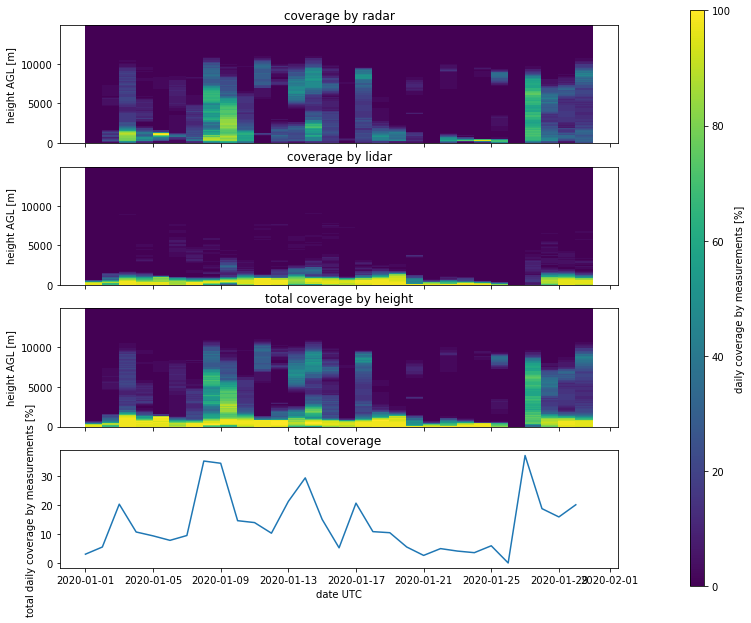

In [8]:
dailyMeasurements = len(hours)/len(days)
totalList = totalList/dailyMeasurements*100
radarList = radarList/dailyMeasurements*100
lidarList = lidarList/dailyMeasurements*100
timelineTotal = timelineTotal/(dailyMeasurements*300)*100
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10), sharex=True, sharey=False)
#fig.suptitle("September 2020", fontsize=16)


days_extende = np.arange(dateBegin, dateEnd+timedelta(days=1), timedelta(days=1)).astype(datetime)

axes[0].set_title("coverage by radar")
#axes[0].axis([0, 24, 0, maxHeight])
X,Y = np.meshgrid(days_extende, heightGrid)
im = axes[0].pcolor(X,Y,radarList.T,cmap='viridis',vmin=0,vmax=100)
axes[0].set_ylabel("height AGL [m]")

axes[1].set_title("coverage by lidar")
#axes[0].axis([0, 24, 0, maxHeight])
im = axes[1].pcolor(X,Y,lidarList.T,cmap='viridis',vmin=0,vmax=100)
axes[1].set_ylabel("height AGL [m]")

axes[2].set_title("total coverage by height")
#axes[0].axis([0, 24, 0, maxHeight])
im = axes[2].pcolor(X,Y,totalList.T,cmap='viridis',vmin=0,vmax=100)
axes[2].set_ylabel("height AGL [m]")


axes[3].set_title("total coverage ")
im2 = axes[3].plot(days,timelineTotal)
axes[3].set_ylabel("total daily coverage by measurements [%]")
axes[3].set_xlabel("date UTC")


cb_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('daily coverage by measurements [%]')

plt.show()